In [51]:
import cv2
import yaml
import pandas as pd
import orbslam3
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [52]:
from orbslam_k2 import ORBSLAM3
from sensor_utils import sync_video, read_synced_logs, convert_logs_to_csv

In [53]:
from sensor_utils import estimate_imu_noise

In [54]:
from main import timedelta_from_string

In [55]:
PROJECT_DIR = Path("..") / ".."
VOCABLUARY_PATH = PROJECT_DIR / "Vocabluary" / "ORBvoc.txt"

VIDEO_FOLDER = Path("cam1_lens100_alt600")
CONFIG_PATH = VIDEO_FOLDER / "config.yaml"
ORB_CONFIG_PATH = VIDEO_FOLDER / "orb_config.yaml"

DATA_DIR = PROJECT_DIR / "data" / "k2" / VIDEO_FOLDER

In [56]:
with open(str(CONFIG_PATH), "r") as f:
    config = yaml.load(f, Loader=yaml.BaseLoader)

In [57]:
offset = pd.Timedelta(minutes=5, seconds=0) # timedelta_from_string(config["offset"])
log_start = timedelta_from_string(config["log_start"]) + offset
video_start = timedelta_from_string(config["video_start"]) + offset

In [58]:
vid = cv2.VideoCapture(str(DATA_DIR / config["video_name"]))
vid = sync_video(vid, video_start, 10)

In [59]:
logs = convert_logs_to_csv(
    str(DATA_DIR / config["raw_log_name"]),
    str(DATA_DIR / config["csv_log_name"])
)

In [60]:
estimate_imu_noise(logs)

IMU.NoiseGyro: 0.1158368889150598
IMU.NoiseAcc: 1.8275090175986226
IMU.GyroWalk: 0.01016279800767177
IMU.AccWalk: 0.30767328132345867
IMU.Frequency: 79.97719002680483


In [61]:
logs = read_synced_logs(str(DATA_DIR / config["csv_log_name"]), 10, log_start)

<Axes: xlabel='x'>

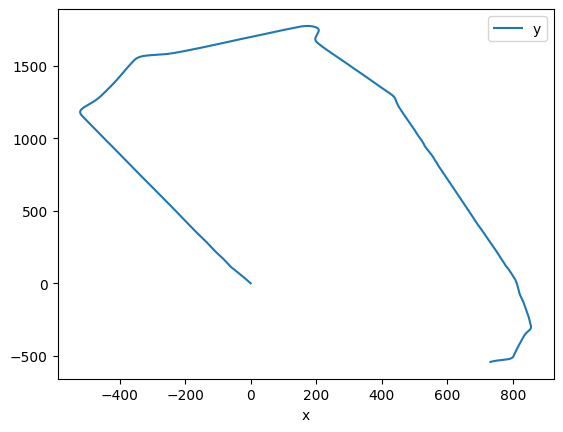

In [62]:
logs.iloc[0:3000].plot(x="x", y="y")

In [63]:
slam = ORBSLAM3(str(VOCABLUARY_PATH), str(ORB_CONFIG_PATH), orbslam3.Sensor.MONOCULAR, False)


ORB-SLAM3 Copyright (C) 2017-2020 Carlos Campos, Richard Elvira, Juan J. Gómez, José M.M. Montiel and Juan D. Tardós, University of Zaragoza.
ORB-SLAM2 Copyright (C) 2014-2016 Raúl Mur-Artal, José M.M. Montiel and Juan D. Tardós, University of Zaragoza.
This program comes with ABSOLUTELY NO WARRANTY;
This is free software, and you are welcome to redistribute it
under certain conditions. See LICENSE.txt.

Input sensor was set to: Monocular
Loading settings from cam1_lens100_alt600/orb_config.yaml
	-Loaded camera 1
	-Loaded image info
	-Loaded ORB settings
	-Loaded viewer settings
	-Loaded Atlas settings
	-Loaded misc parameters
----------------------------------
SLAM settings: 
	-Camera 1 parameters (Pinhole): [ 2339.38 2378.1 1312.66 524.976 ]
	-Camera 1 distortion parameters: [  -0.108419 0.650409 -0.000980865 -0.00764924 -1.69708 ]
	-Original image size: [ 1920 , 1080 ]
	-Current image size: [ 960 , 540 ]
	-Camera 1 parameters after resize: [  1169.69 1189.05 656.332 262.488 ]
	-Seq

Viewer.imageViewScale optional parameter does not exist...
System.LoadAtlasFromFile optional parameter does not exist...
System.SaveAtlasToFile optional parameter does not exist...
System.thFarPoints optional parameter does not exist...


In [64]:
for i in tqdm(range(3000)):
    frame = next(vid)
    log = logs.iloc[i]
    slam.step(frame, log)

  8%|▊         | 245/3000 [00:08<01:13, 37.35it/s]

First KF:1082; Map init KF:0
New Map created with 318 points


 14%|█▍        | 429/3000 [00:12<00:56, 45.86it/s]

In [ ]:
pred_trajectory = slam.get_trajectory_df()

In [22]:
combined_trajectory = pred_trajectory.join(logs, lsuffix="_pred")

In [23]:
combined_trajectory = combined_trajectory.interpolate()

In [28]:
def plot_trajectory(df, column_suffix, ax, title, color):
    x_column = f'x{column_suffix}'
    y_column = f'y{column_suffix}'

    # Plot the trajectory data
    ax.plot(df[x_column], df[y_column], label=title, color=color)
    ax.set_title(title)
    ax.set_xlabel('X (North)')
    ax.set_ylabel('Y (East)')
    ax.legend()

    # Add direction arrows for the trajectory
    arrow_scale = 0.2
    arrow_step = len(df)
    for i in range(0, len(df) - 1, 50):
        dx = df[x_column][i + 1] - df[x_column][i]
        dy = df[y_column][i + 1] - df[y_column][i]
        ax.arrow(
            df[x_column][i], df[y_column][i], 
            arrow_scale * dx, arrow_scale * dy, 
            shape='full', lw=0, length_includes_head=True, 
            head_width=0, color=color
        )


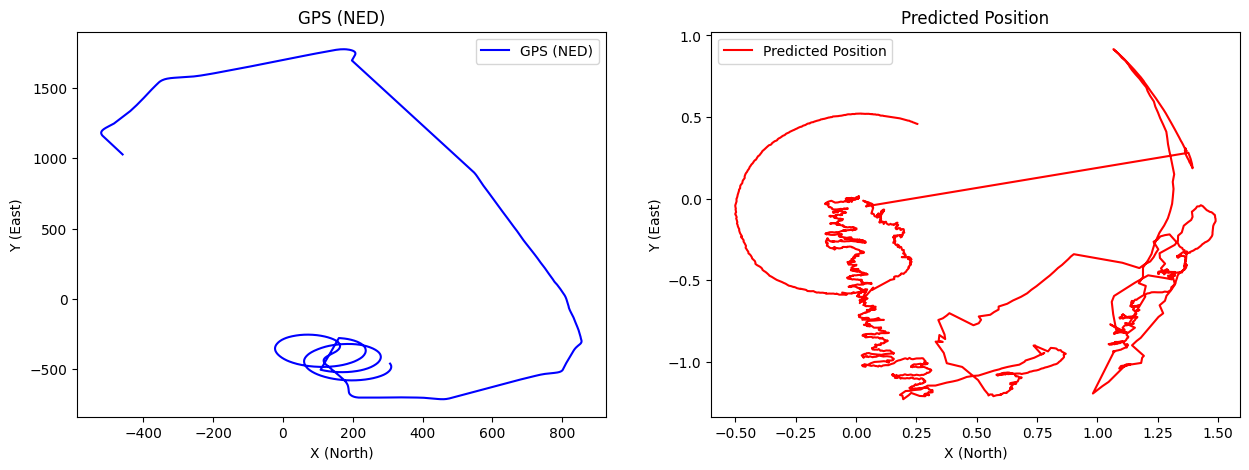

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_trajectory(combined_trajectory, "", ax1, "GPS (NED)", "blue")
plot_trajectory(combined_trajectory, "_pred", ax2, "Predicted Position", "red")

plt.show()
